In [12]:
from fastcore.xtras import load_pickle
import pandas as pd 
import os 
from glob import glob
from pathlib import Path
from scipy.stats import sem
import matplotlib.pyplot as plt
import pycm 
from collections import Counter

FOLDER = 'out'

In [13]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'./{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in out: 181


In [23]:
compiled_res_list = []
conf_mats = []

for results in all_res:
    res_full = load_pickle(results)
    res = res_full['results']
    summary = {
        'size': res_full['train_size'],
        #'test_size': len(res_full['predictions']),
        'representation': res_full['data_summary']['representation'],
        'target': res_full['data_summary']['target'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true']))
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [24]:
compiled_res = pd.DataFrame(compiled_res_list)
compiled_res = compiled_res.loc[compiled_res['target'] != 'ows_bool']
compiled_res = compiled_res.loc[compiled_res['num_epochs']==25]
compiled_res = compiled_res.loc[compiled_res['size']==50]
grouped_res =compiled_res.groupby(['target','bins', 'num_epochs', 'size','representation']).agg(['mean', 'sem'])


In [25]:
grouped_res



accuracy            f1_macro  \
                                                    mean       sem      mean   
target   bins num_epochs size representation                                   
HER_bool 2    25         50   elements_linkers  0.857143  0.008694  0.828876   
                              elements_nodes    0.793651  0.013280  0.750913   
                              elemetns_all      0.865079  0.007937  0.836362   
                              mofid             0.894558  0.007080  0.872595   
                              mofkey            0.894309  0.008130  0.877055   
OER_bool 2    25         50   elements_linkers  0.825397  0.013280  0.778206   
                              elements_nodes    0.896825  0.010039  0.874116   
                              elemetns_all      0.888889  0.007937  0.864438   
                              mofid             0.865079  0.018098  0.832604   
                              mofkey            0.861789  0.016260  0.827666   
VIS_bool 2    25         50   elements_linkers  0.888889  0.005019  0.871363   
                              elements_nodes    0.738095  0.008694  0.669846   
                              elemetns_all      0.896825  0.005019  0.878272   
                              mofid             0.932540  0.003968  0.926985   
                              mofkey            0.951220  0.014082  0.946044   

                                                          f1_micro            \
                                                     sem      mean       sem   
target   bins num_epochs size representation                                   
HER_bool 2    25         50   elements_linkers  0.006864  0.857143  0.008694   
                              elements_nodes    0.017012  0.793651  0.013280   
                              elemetns_all      0.012117  0.865079  0.007937   
                              mofid             0.011185  0.894558  0.007080   
                              mofkey            0.014228  0.894309  0.008130   
OER_bool 2    25         50   elements_linkers  0.016418  0.825397  0.013280   
                              elements_nodes    0.015547  0.896825  0.010039   
                              elemetns_all      0.014527  0.888889  0.007937   
                              mofid             0.030444  0.865079  0.018098   
                              mofkey            0.033852  0.861789  0.016260   
VIS_bool 2    25         50   elements_linkers  0.005868  0.888889  0.005019   
                              elements_nodes    0.014213  0.738095  0.008694   
                              elemetns_all      0.006528  0.896825  0.005019   
                              mofid             0.004281  0.932540  0.003968   
                              mofkey            0.015132  0.951220  0.014082   

                                                   kappa                lr  \
                                                    mean       sem    mean   
target   bins num_epochs size representation                                 
HER_bool 2    25         50   elements_linkers  0.663317  0.013481  0.0003   
                              elements_nodes    0.505806  0.033341  0.0003   
                              elemetns_all      0.677223  0.023163  0.0003   
                              mofid             0.748540  0.021189  0.0003   
                              mofkey            0.756317  0.026843  0.0003   
OER_bool 2    25         50   elements_linkers  0.562746  0.031879  0.0003   
                              elements_nodes    0.750035  0.030176  0.0003   
                              elemetns_all      0.732381  0.027330  0.0003   
                              mofid             0.671001  0.058215  0.0003   
                              mofkey            0.662203  0.061775  0.0003   
VIS_bool 2    25         50   elements_linkers  0.745377  0.011402  0.0003   
                              elements_nodes    0.362883  0.024973  0.0003

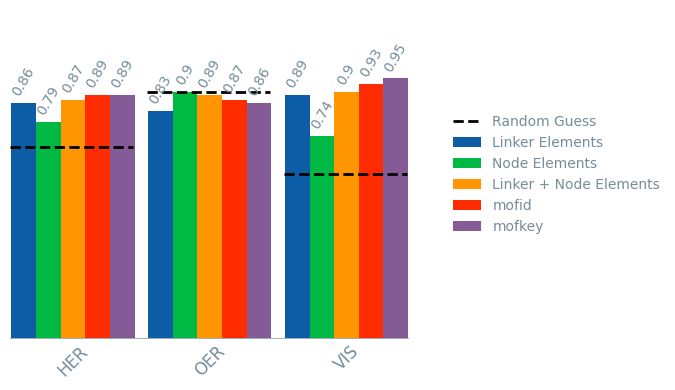

In [27]:
import numpy as np
import sys
sys.path.append("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/")
from plotutils import *

plt.style.use("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/kevin.mplstyle")
grouped_res2 =compiled_res.groupby(['bins', 'num_epochs', 'size','representation', 'target']).agg(['mean', 'sem'])

properties = ['HER', 'OER', 'VIS']
full_acc_dict = {}

for representation in compiled_res['representation'].unique():
    sub_df = grouped_res2.loc[2, 25, 50, representation]


    acc_dict = {representation:[round(i,2) for i in sub_df['accuracy']['mean']]}
    full_acc_dict.update(acc_dict)

new_dict = {'Linker Elements':full_acc_dict['elements_linkers'],
            'Node Elements':full_acc_dict['elements_nodes'],
            'Linker + Node Elements':full_acc_dict['elemetns_all'],
            'mofid':full_acc_dict['mofid'],
            'mofkey':full_acc_dict['mofkey']
            }


COLORS = {'Linker Elements':'#0C5DA5',
            'Node Elements':'#00B945',
            'Linker + Node Elements': '#FF9500',
            'mofid': '#FF2C00',
            'mofkey':'#845B97'
            }

fig, ax = plt.subplots(layout='constrained', figsize = (7,4))
x = np.arange(len(properties))  # the label locations
width = 0.18 # the width of the bars
multiplier = 0

for attribute, measurement in new_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = COLORS[attribute])
    ax.bar_label(rects, padding=3, rotation = 60)
    multiplier += 1

ax.set_ylabel('Accuracy')

ax.get_yaxis().set_visible(False)
ax.spines[['right', 'top', 'left']].set_visible(False)

# Calculate the center of each group of bars
group_centers = x + (width * 2) * np.arange(len(properties))

# Set the x-ticks at the center of each group
ax.set_xticks(group_centers)

# Set the x-labels to your property values and center them between groups
ax.set_xticklabels(properties, rotation=45, ha="center", size =12)

ax.set_xticks(x + width+width, properties)
ax.set_ylim(0, 1.2)

ax.hlines(0.7, -0.1,0.8, colors='black', linestyles='dashed', linewidth= 2)
ax.hlines(0.9, 0.9 ,1.8, colors='black', linestyles='dashed',linewidth= 2)
ax.hlines(0.6, 1.9 ,2.8, colors='black', linestyles='dashed',linewidth= 2, label = 'Random Guess')


ax.legend(loc=(1.1,0.3))

plt.tight_layout()

plt.savefig('HEROERVIS_BarPlot_accuracies.pdf')